Nombre total d'images trouvées : 26
Train : 18 images
Val   : 4 images
Test  : 4 images

=== Exemple de prétraitement + augmentation (train) ===
1) data/images/fce5fec3-2fc8-4a74-bedf-cd2f55eb3195___JR_HL 7920.jpg -> tensor shape : (1, 224, 224, 3) | aug: ['Rotation -12.9°', 'Bruit gaussien σ=0.02']
2) data/images/fcc91cef-9892-4eb2-a3f0-36bdc4e11f59___JR_HL 7687.jpg -> tensor shape : (1, 224, 224, 3) | aug: ['Rotation +0.9°', 'Bruit gaussien σ=0.02']
3) data/images/fec718e1-5498-4c71-802a-d4689ebd69cc___JR_HL 8230.jpg -> tensor shape : (1, 224, 224, 3) | aug: ['Flip horizontal', 'Bruit gaussien σ=0.02']

=== Visualisation AVANT / APRÈS data augmentation ===
Affichage pour : data/images/fce5fec3-2fc8-4a74-bedf-cd2f55eb3195___JR_HL 7920.jpg


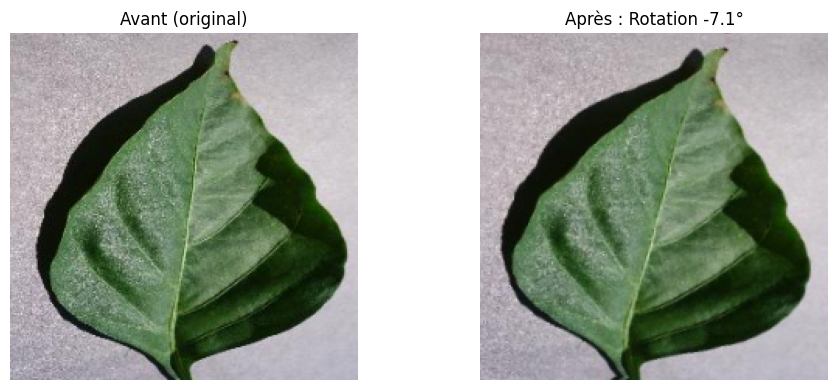

Affichage pour : data/images/fcc91cef-9892-4eb2-a3f0-36bdc4e11f59___JR_HL 7687.jpg


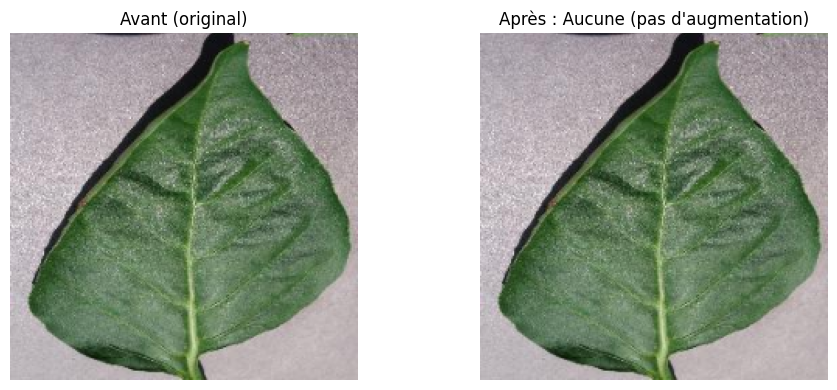

Affichage pour : data/images/fec718e1-5498-4c71-802a-d4689ebd69cc___JR_HL 8230.jpg


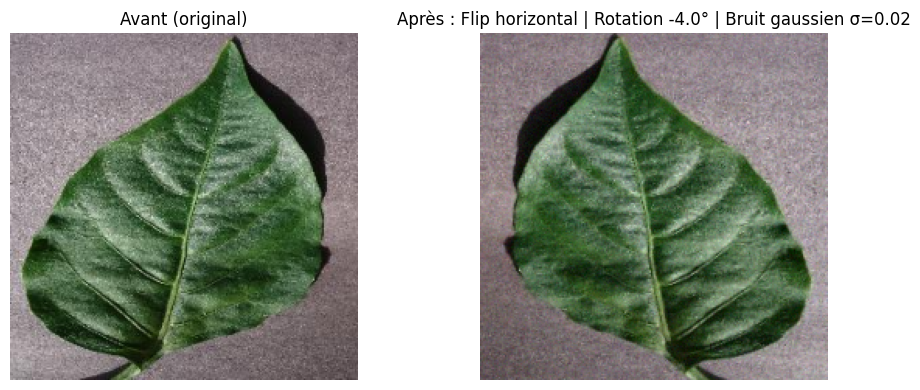

Affichage pour : data/images/fd305c29-a9b6-4720-a568-bf94d9a37c7f___JR_HL 8303.jpg


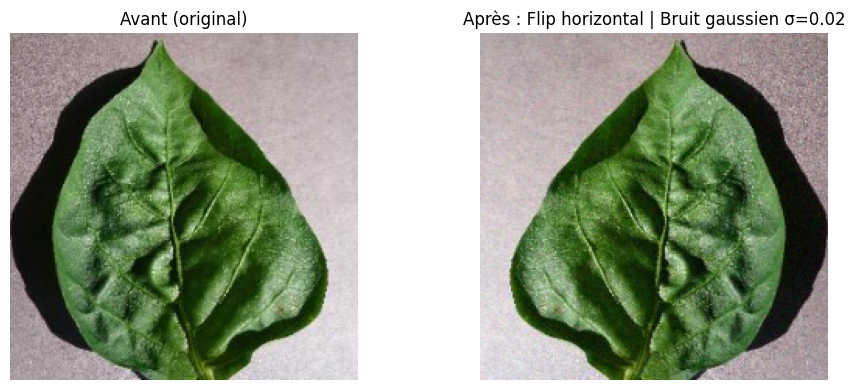

Affichage pour : data/images/fed15b37-0129-4436-a832-d98d9f446f9a___JR_HL 8437.jpg


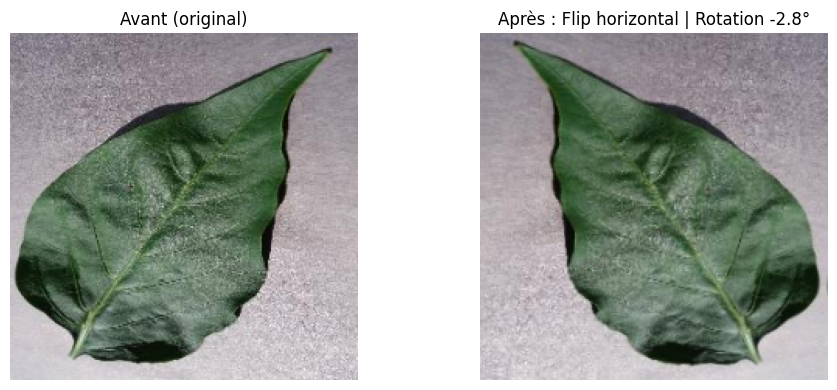

In [8]:
import os
import glob
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# -------------------------------------------------------------------
# 1) Fonction d’augmentation d’images (MODIFIÉE: retourne aussi la liste des modifs)
# -------------------------------------------------------------------
def augment_image(img):
    """
    Applique des augmentations de données simples sur une image :
    - flip horizontal aléatoire
    - légère rotation aléatoire
    - ajout d'un léger bruit gaussien

    Paramètres
    ----------
    img : np.ndarray
        Image au format (H, W, C), en RGB, type float32, normalisée entre [0, 1].

    Retour
    ------
    (img_aug, applied) : (np.ndarray, list[str])
        img_aug  : image augmentée
        applied  : liste textuelle des augmentations réellement appliquées
    """
    applied = []

    # Flip horizontal aléatoire avec probabilité 0.5
    if random.random() < 0.5:
        img = cv2.flip(img, 1)
        applied.append("Flip horizontal")

    # Rotation légère (-15°, +15°) avec probabilité 0.5
    if random.random() < 0.5:
        angle = random.uniform(-15, 15)
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1.0)
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT_101)
        applied.append(f"Rotation {angle:+.1f}°")

    # Ajout d'un léger bruit gaussien avec probabilité 0.5
    if random.random() < 0.5:
        sigma = 0.02
        noise = np.random.normal(0, sigma, img.shape).astype(np.float32)
        img = img + noise
        img = np.clip(img, 0.0, 1.0)
        applied.append(f"Bruit gaussien σ={sigma}")

    if not applied:
        applied.append("Aucune (pas d'augmentation)")

    return img, applied


# -------------------------------------------------------------------
# 2) Fonction de prétraitement + augmentation (MODIFIÉE: gère le retour (img, applied))
# -------------------------------------------------------------------
def preprocess_and_augment(path, target_size=(224, 224), train=True, return_applied=False):
    """
    Lit une image sur le disque, la convertit au bon format, la normalise,
    puis applique éventuellement une augmentation (pour le train).

    Si return_applied=True, retourne aussi la liste des augmentations appliquées.
    """

    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Impossible de lire l'image : {path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0

    applied = ["Aucune (mode train=False)"]

    if train:
        img, applied = augment_image(img)

    # Standardisation ImageNet
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img = (img - mean) / std

    img = np.expand_dims(img, axis=0)

    if return_applied:
        return img, applied
    return img


# -------------------------------------------------------------------
# 3) Fonction utilitaire pour lister les chemins d'images
# -------------------------------------------------------------------
def list_image_paths(data_dir, extensions=("*.jpg", "*.jpeg", "*.png")):
    all_paths = []
    for ext in extensions:
        all_paths.extend(glob.glob(os.path.join(data_dir, ext)))
    return all_paths


# -------------------------------------------------------------------
# 4) Split du dataset (train / validation / test)
# -------------------------------------------------------------------
def split_dataset(image_paths, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=42):
    total = train_ratio + val_ratio + test_ratio
    if abs(total - 1.0) > 1e-6:
        raise ValueError("train_ratio + val_ratio + test_ratio doit être égal à 1.0")

    train_paths, temp_paths = train_test_split(
        image_paths,
        test_size=(1.0 - train_ratio),
        random_state=random_state,
        shuffle=True,
    )

    val_relative = val_ratio / (val_ratio + test_ratio)

    val_paths, test_paths = train_test_split(
        temp_paths,
        test_size=(1.0 - val_relative),
        random_state=random_state,
        shuffle=True,
    )

    return train_paths, val_paths, test_paths


# -------------------------------------------------------------------
# 5) Visualisation AVANT / APRÈS + texte des augmentations au-dessus
# -------------------------------------------------------------------
def show_before_after(img_path, target_size=(224, 224)):
    """
    Affiche l'image originale (avant) et l'image augmentée (après),
    et écrit au-dessus de l'image "après" la liste des modifications appliquées.
    """

    # AVANT (même prétraitement de base mais sans augmentation)
    img_before = cv2.imread(img_path)
    if img_before is None:
        raise ValueError(f"Impossible de lire l'image : {img_path}")

    img_before = cv2.cvtColor(img_before, cv2.COLOR_BGR2RGB)
    img_before = cv2.resize(img_before, target_size)
    img_before = img_before.astype(np.float32) / 255.0

    # APRÈS (augmentation + récupération du texte)
    img_after, applied = augment_image(img_before.copy())
    applied_text = " | ".join(applied)

    # Affichage
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_before)
    plt.title("Avant (original)")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(img_after)
    plt.title(f"Après : {applied_text}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------
# 6) MAIN
# -------------------------------------------------------------------
if __name__ == "__main__":
    data_dir = "data/images"

    image_paths = list_image_paths(data_dir)
    print(f"Nombre total d'images trouvées : {len(image_paths)}")

    if len(image_paths) == 0:
        raise RuntimeError(
            f"Aucune image trouvée dans {data_dir}. "
            f"Vérifie le chemin et les extensions."
        )

    train_paths, val_paths, test_paths = split_dataset(image_paths)

    print(f"Train : {len(train_paths)} images")
    print(f"Val   : {len(val_paths)} images")
    print(f"Test  : {len(test_paths)} images")

    print("\n=== Exemple de prétraitement + augmentation (train) ===")
    for i, img_path in enumerate(train_paths[:3]):
        img_tensor, applied = preprocess_and_augment(
            img_path, target_size=(224, 224), train=True, return_applied=True
        )
        print(f"{i+1}) {img_path} -> tensor shape : {img_tensor.shape} | aug: {applied}")

    print("\n=== Visualisation AVANT / APRÈS data augmentation ===")
    for img_path in train_paths[:5]:
        print(f"Affichage pour : {img_path}")
        show_before_after(img_path, target_size=(224, 224))


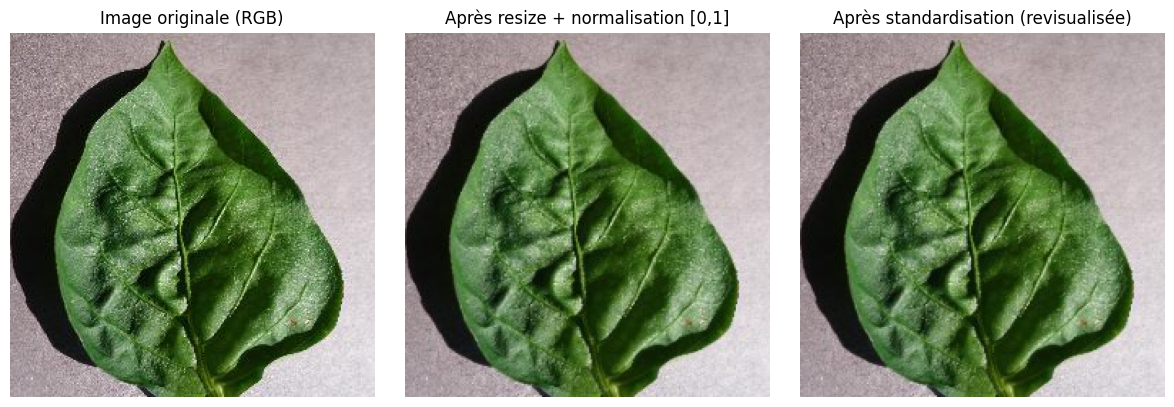

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def preprocess_image_steps(path, target_size=(224, 224)):
    # 1) Charger l'image
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f"Impossible de lire l'image : {path}")

    # 2) BGR -> RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 3) Resize
    img_resized = cv2.resize(img_rgb, target_size)

    # 4) Normalisation [0,1]
    img_norm = img_resized.astype(np.float32) / 255.0

    # 5) Standardisation ImageNet
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_std = (img_norm - mean) / std

    return img_rgb, img_norm, img_std


def show_preprocessing(path, target_size=(224, 224)):
    img_original, img_norm, img_std = preprocess_image_steps(path, target_size)

    # Dé-standardisation pour affichage
    mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
    std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
    img_std_vis = np.clip(img_std * std + mean, 0, 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_original)
    plt.title("Image originale (RGB)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(img_norm)
    plt.title("Après resize + normalisation [0,1]")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_std_vis)
    plt.title("Après standardisation (revisualisée)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# -------------------------
# Exemple d'utilisation
# -------------------------
image_path = "data/images/fd305c29-a9b6-4720-a568-bf94d9a37c7f___JR_HL 8303.jpg"
show_preprocessing(image_path, target_size=(224, 224))
